# Explore here

In [20]:
import pandas as pd
import numpy as np
from datetime import datetime



In [21]:
# Apertura de datasets

#El archivo appearence_agrupado, ha sido trabajado en el google colab en el siguiente link:
#https://colab.research.google.com/drive/1kkoDlp4htYlhvd1pJ4Mg8GcqiJniWnwx#scrollTo=55sTvyXtUQs0
#pues el original tiene un tamaño grande y no permitía trabajarlo en github.

appearence = pd.read_csv("/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/appearence_agrupado.csv")
#club_games = pd.read_csv("/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/club_games.csv")
#clubs = pd.read_csv("/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/clubs.csv")
#competitions = pd.read_csv("/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/competitions.csv")
#game_events = pd.read_csv("/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/game_events.csv")
#game_lineups = pd.read_csv("/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/game_lineups.csv")
transfers = pd.read_csv("/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/transfers.csv")
players = pd.read_csv("/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/players.csv")
#games = pd.read_csv("/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/games.csv")
player_valuations = pd.read_csv("/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/player_valuations.csv")

#  Datasets en un diccionario para organizarlos
#datasets = {"Appearence": appearence, "Club Games": club_games, "Clubs": clubs, "Competitions": competitions,
 #           "Game events":game_events, "Game Lineups":game_lineups, "Transfers":transfers, "Players":players,
  #          "Games":games, "Player Valuations":player_valuations}

ds_players_info= {"Appearence": appearence, "Players":players, "Player Valuations":player_valuations}

for name, dataset in ds_players_info.items():
    print(f"El shape de {name}: {dataset.shape}")


El shape de Appearence: (203718, 12)
El shape de Players: (32480, 23)
El shape de Player Valuations: (494561, 5)


In [22]:
for name, dataset in ds_players_info.items():
    print(f"Las columnas de {name}: {dataset.columns}")

Las columnas de Appearence: Index(['player_id', 'year', 'competition_id', 'club_name', 'player_name',
       'matches_played', 'yellow_cards', 'red_cards', 'goals', 'assists',
       'minutes_played', 'age'],
      dtype='object')
Las columnas de Players: Index(['player_id', 'first_name', 'last_name', 'name', 'last_season',
       'current_club_id', 'player_code', 'country_of_birth', 'city_of_birth',
       'country_of_citizenship', 'date_of_birth', 'sub_position', 'position',
       'foot', 'height_in_cm', 'contract_expiration_date', 'agent_name',
       'image_url', 'url', 'current_club_domestic_competition_id',
       'current_club_name', 'market_value_in_eur',
       'highest_market_value_in_eur'],
      dtype='object')
Las columnas de Player Valuations: Index(['player_id', 'date', 'market_value_in_eur', 'current_club_id',
       'player_club_domestic_competition_id'],
      dtype='object')


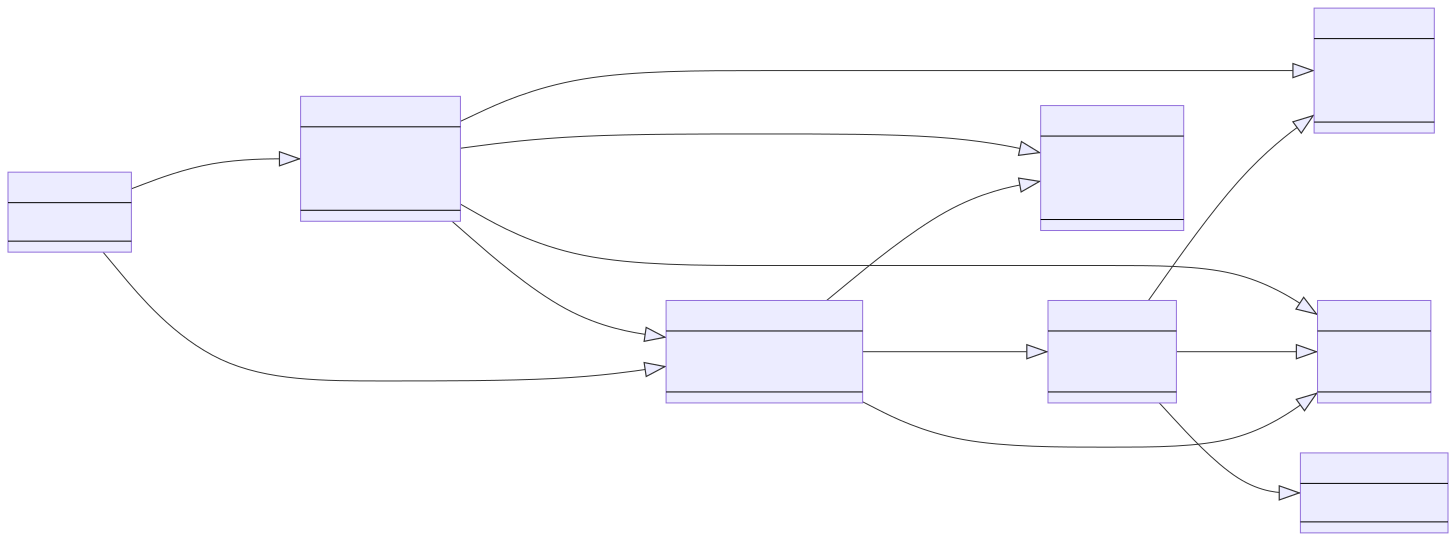

In [23]:
from IPython.display import SVG, display

display(SVG(filename="/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/diagram.svg"))

### Dataset filtrados por columnas relevantes:

In [24]:
#appearence_filtered=appearence.drop(["appearance_id", "player_current_club_id"], axis = 1)
player_valuations_filtered=player_valuations.drop(["current_club_id", "player_club_domestic_competition_id"], axis = 1)
players_filtered=players.drop(["first_name", "last_name", "last_season", "current_club_id", "player_code", "contract_expiration_date","agent_name","image_url","url", "current_club_domestic_competition_id","current_club_name","market_value_in_eur"], axis = 1)

Groupby Player_valuation

In [25]:
# 1. Convertir la columna 'date' al formato datetime (si no lo está ya)
player_valuations_filtered['date'] = pd.to_datetime(player_valuations_filtered['date'])

# 2. Crear una nueva columna que contenga el año del partido
player_valuations_filtered['year'] = player_valuations_filtered['date'].dt.year

# 3. Agrupar por 'player_id' y 'year', y calcular agregados para cada columna relevante
gb_player_val = player_valuations_filtered.groupby(['player_id', 'year']).agg({
    "market_value_in_eur":"mean"
}).reset_index()

# 4. Ver el resultado
print(gb_player_val)

        player_id  year  market_value_in_eur
0              10  2004            7000000.0
1              10  2005           12000000.0
2              10  2006           25000000.0
3              10  2007           23000000.0
4              10  2008           20000000.0
...           ...   ...                  ...
249886    1294052  2024             150000.0
249887    1296876  2024             500000.0
249888    1302421  2024             100000.0
249889    1306131  2024             100000.0
249890    1306851  2024              50000.0

[249891 rows x 3 columns]


Hacemos el merge (hay algunas valuaciones que se pierden)

In [26]:
# Hacemos el merge:
app_plval_merged = pd.merge(appearence, gb_player_val, on=['player_id', 'year'], how='inner')
print(app_plval_merged.shape)
app_plval_merged

(193246, 13)


,player_id,year,competition_id,club_name,player_name,matches_played,yellow_cards,red_cards,goals,assists,minutes_played,age,market_value_in_eur
0,10,2012,EL,Società Sportiva Lazio S.p.A.,Miroslav Klose,2,0.000000,0.0,0.000000,0.000000,52.000000,34.000000,6000000.0
1,10,2012,ELQ,Società Sportiva Lazio S.p.A.,Miroslav Klose,1,1.000000,0.0,1.000000,0.000000,83.000000,34.000000,6000000.0
2,10,2012,IT1,Società Sportiva Lazio S.p.A.,Miroslav Klose,17,0.294118,0.0,0.588235,0.058824,76.235294,34.000000,6000000.0
3,10,2013,CIT,Società Sportiva Lazio S.p.A.,Miroslav Klose,2,0.500000,0.0,0.000000,0.000000,80.000000,34.000000,3000000.0
4,10,2013,EL,Società Sportiva Lazio S.p.A.,Miroslav Klose,3,0.333333,0.0,0.000000,0.000000,22.333333,34.333333,3000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
193241,1296876,2024,ES1,Real Club Deportivo Mallorca S.A.D.,Marc Domènech,3,0.000000,0.0,0.000000,0.000000,38.333333,17.000000,500000.0
193242,1302421,2024,UKR1,ZAO FK Chornomorets Odessa,João Neto,4,0.000000,0.0,0.000000,0.000000,26.750000,21.000000,100000.0
193243,1302421,2024,UKRP,ZAO FK Chornomorets Odessa,João Neto,1,0.000000,0.0,0.000000,0.000000,90.000000,21.000000,100000.0
193244,1306851,2024,DK1,Randers Fodbold Club,Hakim Sulemana,4,0.000000,0.0,0.000000,0.000000,9.750000,19.000000,50000.0


Otros tipos de merge:

In [27]:
# Hacemos el merge:
app_plval_merged2 = pd.merge(appearence, gb_player_val, on=['player_id', 'year'], how='right')
print(app_plval_merged2.shape)

app_plval_merged3 = pd.merge(appearence, gb_player_val, on=['player_id', 'year'], how='left')
print(app_plval_merged3.shape)

app_plval_merged4 = pd.merge(appearence, gb_player_val, on=['player_id', 'year'], how='outer')
print(app_plval_merged4.shape)

(348798, 13)
(203718, 13)


(359270, 13)


Aquí el merge con la información de los jugadores 

In [28]:
df_merge = pd.merge(app_plval_merged, players_filtered, on=['player_id'], how='inner')
df_merge = df_merge.drop(["name"], axis = 1)
print(df.shape)
duplicados = df_merge.duplicated()
num_duplicados = duplicados.sum()
print(f"La cantidad de duplicados en nuestro dataset: {num_duplicados}")
df_merge.info()

(193246, 22)


La cantidad de duplicados en nuestro dataset: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193246 entries, 0 to 193245
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   player_id                    193246 non-null  int64  
 1   year                         193246 non-null  int64  
 2   competition_id               193246 non-null  object 
 3   club_name                    193246 non-null  object 
 4   player_name                  193246 non-null  object 
 5   matches_played               193246 non-null  int64  
 6   yellow_cards                 193246 non-null  float64
 7   red_cards                    193246 non-null  float64
 8   goals                        193246 non-null  float64
 9   assists                      193246 non-null  float64
 10  minutes_played               193246 non-null  float64
 11  age                          193246 non-null  float64
 12  market_val

In [29]:
df_merge.columns

Index(['player_id', 'year', 'competition_id', 'club_name', 'player_name',
       'matches_played', 'yellow_cards', 'red_cards', 'goals', 'assists',
       'minutes_played', 'age', 'market_value_in_eur', 'country_of_birth',
       'city_of_birth', 'country_of_citizenship', 'date_of_birth',
       'sub_position', 'position', 'foot', 'height_in_cm',
       'highest_market_value_in_eur'],
      dtype='object')

Nuestro dataset cuenta con la información de distintos jugadores, separadas por año y juntando la información de distintos partidos separada por competiciones, con la respectiva valuación en euros de cada jugador en ese momento.

- Contamos con 196.238 y 22 atributos.
- No tenemos datos duplicados.
- Contamos con algunos valores nulos en las variables "country_of_birth", "city_of_birth", "country_of_citizenship", "sub_position", "foot", "height_in_cm".
- VER 9 características son numéricas, entre las cuales se encuentra nuestra variable objetivo Outcome que está codificada con el valor 0 para quién no posee diabetes y valor 1 para quién sí lo hace.

### Análisis Exploratorio de Datos

Carácterísticas relevantes:

- Nustra variable a predecir será "market_value_in_eur", que es un valor numérico.
- Nos quedaremos con las siguientes características para predecir nuestro objetivo:
    - competition_id (cat): el tipo de competición donde se jugó ese partido.
    - club_name (cat): El nombre del club en el cual pertenece el jugador ese año.
    - matches_played (num): cantidad de partidos jugados en un año, separados por competencia.
    - yellow_cards (num): promedio de tarjetas amarillas recibidas en un año, separados por competencia.
    - red_cards (num): promedio de tarjetas rojas recibidas en un año, separados por competencia.
    - goals (num): promedio de cantidas de goles hechos en un año, separados por competencia.
    - assists (num): promedio de cantidas de asistencias hechos en un año, separados por competencia.
    - minutes_played (num): promedio de minutos jugados en un año, separados por competencia.
    - age (num): edad del jugador en ese año.
    - country_of_birth (cat): país de nacimiento del jugador.
    - city_of_birth (cat): ciudad de nacimiento del jugador.
    - position (cat): posición general del jugador.
    - sub_position (cat): posición específica del jugador.
    - foot (cat): pie hábil del jugador.
    - height_in_cm (num): altura del jugador.
    - highest_market_value_in_eur (num): mayor cotización del jugador hasta el momento.
    - market_value_in_eur (num): La cotización del jugador por año. (Nustra variable objetivo)

Eliminamos variables no relevantes:
- player_id, player_name: por ser valores irrelevantes en nuestra predicción.
- year: se utilizó para las agrupaciones de los partidos y valuaciones por año.
- country_of_citizenship: nos quedamos con el país y ciudad de nacimiento.
- date_of_birth: se utilizó para calcular la edad de los jugadores en los recpectivos años.

In [30]:
df_filtrado=df_merge.drop(['player_id', 'year', 'player_name','country_of_citizenship', 'date_of_birth'], axis = 1)
df_filtrado.shape

(193246, 17)

Análisis de valores nulos

In [31]:
print(df_filtrado.isnull().sum().sort_values(ascending=False))


country_of_birth               6091
city_of_birth                  3415
foot                           3141
height_in_cm                   2344
sub_position                    211
competition_id                    0
club_name                         0
yellow_cards                      0
matches_played                    0
age                               0
minutes_played                    0
assists                           0
goals                             0
red_cards                         0
market_value_in_eur               0
position                          0
highest_market_value_in_eur       0
dtype: int64


In [32]:
df_sin_nulos = df_filtrado.dropna()
print(df_sin_nulos.shape)
df_sin_nulos.isnull().sum().sort_values(ascending=False)
df=df_sin_nulos

(183607, 17)


Eliminando los valores nulos, tenemos un total de 183.607 datos.

### Análisis univarido de variable numéricas.

In [34]:
messi=df_merge[df_merge['player_id'] == 28003]
messi

,player_id,year,competition_id,club_name,player_name,matches_played,yellow_cards,red_cards,goals,assists,...,market_value_in_eur,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,position,foot,height_in_cm,highest_market_value_in_eur
18799,28003,2012,CDR,Futbol Club Barcelona,Lionel Messi,1,0.000000,0.0,2.000000,0.000000,...,1.100000e+08,Argentina,Rosario,Argentina,1987-06-24 00:00:00,Right Winger,Attack,left,170.0,180000000.0
18800,28003,2012,CL,Futbol Club Barcelona,Lionel Messi,6,0.000000,0.0,0.833333,0.500000,...,1.100000e+08,Argentina,Rosario,Argentina,1987-06-24 00:00:00,Right Winger,Attack,left,170.0,180000000.0
18801,28003,2012,ES1,Futbol Club Barcelona,Lionel Messi,17,0.058824,0.0,1.529412,0.352941,...,1.100000e+08,Argentina,Rosario,Argentina,1987-06-24 00:00:00,Right Winger,Attack,left,170.0,180000000.0
18802,28003,2012,SUC,Futbol Club Barcelona,Lionel Messi,2,0.000000,0.0,1.000000,0.000000,...,1.100000e+08,Argentina,Rosario,Argentina,1987-06-24 00:00:00,Right Winger,Attack,left,170.0,180000000.0
18803,28003,2013,CDR,Futbol Club Barcelona,Lionel Messi,4,0.250000,0.0,0.500000,0.250000,...,1.200000e+08,Argentina,Rosario,Argentina,1987-06-24 00:00:00,Right Winger,Attack,left,170.0,180000000.0
18804,28003,2013,CL,Futbol Club Barcelona,Lionel Messi,8,0.000000,0.0,1.125000,0.000000,...,1.200000e+08,Argentina,Rosario,Argentina,1987-06-24 00:00:00,Right Winger,Attack,left,170.0,180000000.0
18805,28003,2013,ES1,Futbol Club Barcelona,Lionel Messi,26,0.000000,0.0,1.076923,0.423077,...,1.200000e+08,Argentina,Rosario,Argentina,1987-06-24 00:00:00,Right Winger,Attack,left,170.0,180000000.0
18806,28003,2013,SUC,Futbol Club Barcelona,Lionel Messi,2,0.000000,0.0,0.000000,0.000000,...,1.200000e+08,Argentina,Rosario,Argentina,1987-06-24 00:00:00,Right Winger,Attack,left,170.0,180000000.0
18807,28003,2014,CDR,Futbol Club Barcelona,Lionel Messi,6,0.166667,0.0,0.833333,0.500000,...,1.200000e+08,Argentina,Rosario,Argentina,1987-06-24 00:00:00,Right Winger,Attack,left,170.0,180000000.0
18808,28003,2014,CL,Futbol Club Barcelona,Lionel Messi,10,0.000000,0.0,1.000000,0.200000,...,1.200000e+08,Argentina,Rosario,Argentina,1987-06-24 00:00:00,Right Winger,Attack,left,170.0,180000000.0


In [ ]:
messi_player=players[players['player_id'] == 28003]
messi_player

,player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,...,foot,height_in_cm,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name,market_value_in_eur,highest_market_value_in_eur
2347,28003,Lionel,Messi,Lionel Messi,2022,583,lionel-messi,Argentina,Rosario,Argentina,...,left,170.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/lionel-messi/p...,FR1,Paris Saint-Germain Football Club,35000000.0,180000000.0


In [17]:
messi_pl_val=player_valuations[player_valuations['player_id'] == 28003]
messi_pl_val

,player_id,date,market_value_in_eur,current_club_id,player_club_domestic_competition_id
2248,28003,2004-12-20,3000000,583,FR1
4728,28003,2005-12-28,5000000,583,FR1
4959,28003,2006-01-20,15000000,583,FR1
9674,28003,2007-07-26,40000000,583,FR1
11042,28003,2007-09-12,60000000,583,FR1
14290,28003,2008-02-04,55000000,583,FR1
17826,28003,2008-07-10,55000000,583,FR1
23698,28003,2009-01-26,55000000,583,FR1
25586,28003,2009-04-28,60000000,583,FR1
28672,28003,2009-07-22,70000000,583,FR1
